In [85]:
reInstaller = False

if reInstaller == True:
  import os
  os.system("pip install torch==1.9.0+cu111 torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric numpy scipy tqdm matplotlib git")
  if not os.path.isdir("point-transformer"):
      os.system("https://github.com/TheoGachet/point-transformer")
  print("✅ Dépendances installées et repo cloné")


In [86]:
if reInstaller == True:
  os.chdir("point-transformer/lib/pointops")
  os.system("python setup.py build install")
  os.chdir("../..")
  print("✅ Extensions CUDA compilées")

In [87]:

if reInstaller == True:
  import torch

  # Formatte la version de torch et CUDA
  TORCH = torch.__version__.split('+')[0]
  CUDA = 'cu' + torch.version.cuda.replace('.', '')

  print("Installing for PyTorch", TORCH, "with CUDA", CUDA)

  # Installe les dépendances nécessaires
  os_command = (
      f"pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html && "
      f"pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html && "
      f"pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html && "
      f"pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html && "
      "pip install torch-geometric"
  )

  print(os.popen(os_command).read())
  print("✅ torch_geometric et dépendances installés")


---

In [88]:
import os
import glob
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import PointTransformerConv, knn_graph
from torch.nn import Linear
from tqdm import tqdm


In [89]:
from torch_geometric.nn import knn_graph

class LuSNARDataset(Dataset):
    def __init__(self, folder):
        self.files = sorted(glob.glob(os.path.join(folder, "*.npz")))
        assert self.files, f"Aucun fichier trouvé dans {folder}"

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        data = np.load(self.files[i], allow_pickle=True)
        pos = torch.from_numpy(data["lidar_points"]).float()
        y = torch.from_numpy(data["lidar_category"]).long()

        # Filtrer les labels invalides
        mask = y != -1
        pos, y = pos[mask], y[mask]

        # Relabel consécutif
        unique = y.unique(sorted=True)
        mapping = {v.item(): i for i, v in enumerate(unique)}
        y = torch.tensor([mapping[v.item()] for v in y], dtype=torch.long)

        # Ajouter edge_index ici (auto batch non supporté par knn_graph sans batch)
        edge_index = knn_graph(pos, k=16, loop=False)

        return Data(pos=pos, y=y, edge_index=edge_index)


In [90]:
import torch.nn.functional as F
from torch_geometric.nn import PointTransformerConv, knn_graph
from torch.nn import Linear

class PTNet(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.lin_in = Linear(3, 64)
        self.conv1 = PointTransformerConv(64, 64)
        self.conv2 = PointTransformerConv(64, 128)
        self.lin_out = Linear(128, num_classes)

    def forward(self, data):
        x, pos, batch = data.pos, data.pos, data.batch
        x = F.relu(self.lin_in(x))

        edge_index = knn_graph(pos, k=16, batch=batch)

        x = F.relu(self.conv1(x, pos, edge_index))  # ✅ pos est bien fourni
        x = F.relu(self.conv2(x, pos, edge_index))  # ✅ idem

        return self.lin_out(x)


In [91]:
from torch_geometric.loader import DataLoader
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PTNet(num_classes).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)

for epoch in range(5):
    print(f"\n➡️ Epoch {epoch+1} démarrée")
    model.train()
    total_loss = 0.0

    for i, batch in enumerate(loader):
        print(f"\n-- Batch {i+1}/{len(loader)} --")
        print(" batch.pos shape:", batch.pos.shape)
        print(" batch.y shape:", batch.y.shape)

        batch = batch.to(device)

        # debug before forward
        print(" batch transferred to device:", flag := batch.pos.is_cuda)

        try:
            pred = model(batch)
        except Exception as e:
            print("❌ Erreur dans model(batch):", e)
            break

        print(" pred shape:", pred.shape)
        print(" unique labels:", torch.unique(batch.y))

        try:
            loss = criterion(pred, batch.y)
        except Exception as e:
            print("❌ Erreur dans criterion():", e)
            break

        print(" loss computed:", loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item()

    avg = total_loss / (i+1)
    print(f"\n✅ Epoch {epoch+1} terminée — Loss moyenne: {avg:.4f}")



➡️ Epoch 1 démarrée

-- Batch 1/75 --
 batch.pos shape: torch.Size([33217, 3])
 batch.y shape: torch.Size([33217])
 batch transferred to device: False
 pred shape: torch.Size([33217, 2])
 unique labels: tensor([0, 1])
 loss computed: 0.6938016414642334

-- Batch 2/75 --
 batch.pos shape: torch.Size([34080, 3])
 batch.y shape: torch.Size([34080])
 batch transferred to device: False


KeyboardInterrupt: 

In [92]:
batch = batch.to(device)
print("Debug signature:", model.conv1.forward.__code__.co_varnames[:3])
# => should print: ('self', 'x', 'pos', 'edge_index')
pred = model(batch)


Debug signature: ('self', 'x', 'pos')


In [93]:
import torch, glob, numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import PointTransformerConv, knn_graph
from torch.nn import Linear
from tqdm import tqdm

# Dataset minimal
class LuSNARDataset(Dataset):
    def __init__(self, folder):
        self.paths = sorted(glob.glob(f"{folder}/*.npz"))
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        d = np.load(self.paths[i], allow_pickle=True)
        pts = torch.from_numpy(d['lidar_points']).float()
        lbl = torch.from_numpy(d['lidar_category']).long()
        mask = lbl != -1
        return Data(pos=pts[mask], y=lbl[mask], batch=torch.zeros(int(mask.sum()),dtype=torch.long))

# Modèle corrigé
class PTNet(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.lin_in = Linear(3,64)
        self.conv1 = PointTransformerConv(64,64)
        self.conv2 = PointTransformerConv(64,128)
        self.out = Linear(128, num_classes)

    def forward(self, data):
        x, pos, batch = data.pos, data.pos, data.batch
        x = F.relu(self.lin_in(x))
        edge_index = knn_graph(pos, k=16, batch=batch)
        x = F.relu(self.conv1(x, pos, edge_index))
        x = F.relu(self.conv2(x, pos, edge_index))
        return self.out(x)

# Préparation
folder = "/content/point-transformer/data/moon"
dataset = LuSNARDataset(folder)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Détermination des classes
all_y = torch.cat([d.y for d in dataset])
num_classes = int(all_y.max())+1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PTNet(num_classes).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = torch.nn.CrossEntropyLoss()

# Entraînement
for epoch in range(3):
    model.train()
    running = 0
    for batch in tqdm(loader):
        batch = batch.to(device)
        pred = model(batch)  # correct call with 3 args in conv
        loss = crit(pred, batch.y)
        opt.zero_grad(); loss.backward(); opt.step()
        running += loss.item()
    print(f"Epoch {epoch+1} avg loss: {running/len(loader):.4f}")


  5%|▌         | 4/75 [00:24<07:16,  6.14s/it]


KeyboardInterrupt: 

---

In [102]:
# 🔥 Cellule complète – entraînement Point Transformer avec barre de progression

import os, glob, numpy as np, torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import PointTransformerConv, knn_graph
from torch.nn import Linear
from tqdm.notebook import tqdm  # barre progress en notebook

# 1️⃣ Classe Dataset pour tes fichiers .npz
class LuSNARDataset(Dataset):
    def __init__(self, folder):
        self.paths = sorted(glob.glob(f"{folder}/*.npz"))
        assert self.paths, f"Aucun .npz trouvé dans {folder}"
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        d = np.load(self.paths[i], allow_pickle=True)
        pts = torch.from_numpy(d['lidar_points']).float()
        lbl = torch.from_numpy(d['lidar_category']).long()
        mask = lbl != -1
        pts, lbl = pts[mask], lbl[mask]
        unique = lbl.unique(sorted=True)
        mapping = {v.item(): idx for idx, v in enumerate(unique)}
        lbl = torch.tensor([mapping[v.item()] for v in lbl], dtype=torch.long)
        batch = torch.zeros(pts.size(0), dtype=torch.long)
        return Data(pos=pts, y=lbl, batch=batch)

# 2️⃣ Préparer dataset & loader
folder = "/content/point-transformer/data/moon"
dataset = LuSNARDataset(folder)
loader = DataLoader(dataset, batch_size=2, shuffle=True)
all_y = torch.cat([d.y for d in dataset])
num_classes = int(all_y.max().item()) + 1
print(f"✅ {len(dataset)} samples — num_classes = {num_classes}")

# 3️⃣ Définition du modèle Point Transformer
class PTNet(torch.nn.Module):
    def __init__(self, nc):
        super().__init__()
        self.lin_in = Linear(3, 64)
        self.conv1 = PointTransformerConv(64, 64)
        self.conv2 = PointTransformerConv(64, 128)
        self.head = Linear(128, nc)
    def forward(self, data):
        x, pos, batch = data.pos, data.pos, data.batch
        x = F.relu(self.lin_in(x))
        edge_index = knn_graph(pos, k=16, batch=batch)
        x = F.relu(self.conv1(x, pos, edge_index=edge_index))
        x = F.relu(self.conv2(x, pos, edge_index=edge_index))
        return self.head(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PTNet(num_classes).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = torch.nn.CrossEntropyLoss()

# 4️⃣ Entraînement avec barre de progression
for epoch in range(3):
    print(f"\n➡️ Epoch {epoch+1}")
    model.train()
    total_loss = 0.0

    for batch in tqdm(loader, desc=f"Epoch {epoch+1}", total=len(loader)):
        batch = batch.to(device)
        pred = model(batch)
        loss = crit(pred, batch.y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()

    print(f"✅ Epoch {epoch+1} — avg loss: {total_loss/len(loader):.4f}")


✅ 300 samples — num_classes = 2

➡️ Epoch 1


Epoch 1:   0%|          | 0/150 [00:00<?, ?it/s]

✅ Epoch 1 — avg loss: 0.4275

➡️ Epoch 2


Epoch 2:   0%|          | 0/150 [00:00<?, ?it/s]

✅ Epoch 2 — avg loss: 0.3639

➡️ Epoch 3


Epoch 3:   0%|          | 0/150 [00:00<?, ?it/s]

✅ Epoch 3 — avg loss: 0.3268


In [103]:
import torch

def evaluate(loader, model, num_classes):
    model.eval()
    total_correct = 0
    total_points = 0
    hist = torch.zeros((num_classes, num_classes), dtype=torch.long)
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            logits = model(batch)
            preds = logits.argmax(dim=1)
            mask = batch.y >= 0
            p = preds[mask]; t = batch.y[mask]
            total_correct += int((p == t).sum())
            total_points += int(t.size(0))
            for gt, pr in zip(t, p):
                hist[gt, pr] += 1

    oa = total_correct / total_points
    iou = torch.diag(hist).float() / (hist.sum(1) + hist.sum(0) - torch.diag(hist)).float()
    miou = iou.mean().item()
    return oa, miou

oa, miou = evaluate(loader, model, num_classes)
print(f"✅ Évaluation → OA: {oa:.3f}, mIoU: {miou:.3f}")


✅ Évaluation → OA: 0.889, mIoU: 0.793


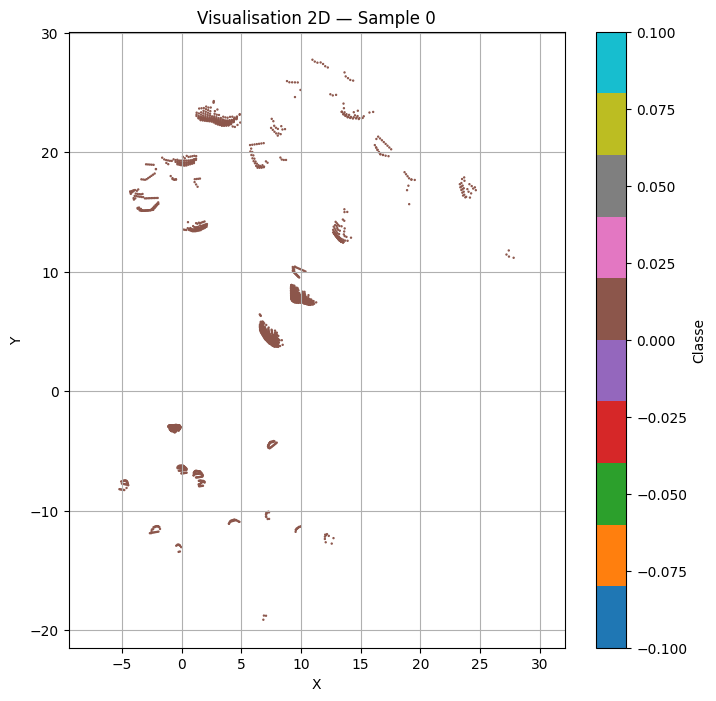

In [105]:
import matplotlib.pyplot as plt

def visualize_sample(index):
    sample = dataset[index]  # ici, pas besoin de DataLoader ou batch
    pos = sample.pos.cpu().numpy()
    labels = sample.y.cpu().numpy()

    fig = plt.figure(figsize=(8, 8))
    scatter = plt.scatter(pos[:, 0], pos[:, 1], c=labels, cmap='tab10', s=0.5)
    plt.colorbar(scatter, label='Classe')
    plt.title(f"Visualisation 2D — Sample {index}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis("equal")
    plt.grid(True)
    plt.show()

visualize_sample(0)


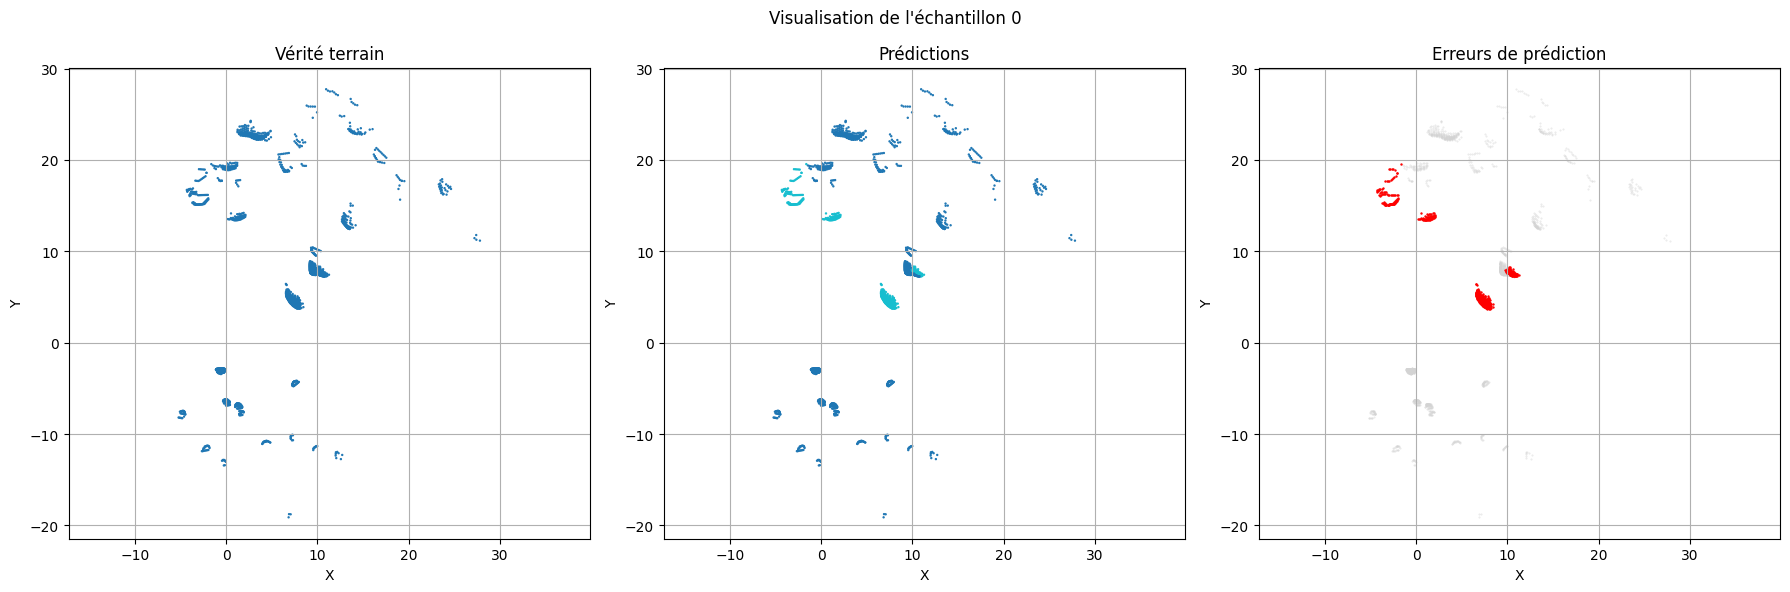

In [111]:
import matplotlib.pyplot as plt
from torch_geometric.data import Batch

def visualize_prediction(index):
    model.eval()
    sample = dataset[index].to(device)
    with torch.no_grad():
        batch = Batch.from_data_list([sample])
        pred_logits = model(batch)
        pred = pred_logits.argmax(dim=1).squeeze().cpu().numpy()

    true = sample.y.cpu().numpy()
    pos = sample.pos.cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].scatter(pos[:, 0], pos[:, 1], c=true, cmap='tab10', s=0.5)
    axs[0].set_title("Vérité terrain")

    axs[1].scatter(pos[:, 0], pos[:, 1], c=pred, cmap='tab10', s=0.5)
    axs[1].set_title("Prédictions")

    mask = (pred != true) & (true != -1)
    axs[2].scatter(pos[:, 0], pos[:, 1], c='lightgrey', s=0.2, alpha=0.5)
    axs[2].scatter(pos[mask, 0], pos[mask, 1], c='red', s=0.5)
    axs[2].set_title("Erreurs de prédiction")

    for ax in axs:
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.axis("equal")
        ax.grid(True)

    plt.suptitle(f"Visualisation de l'échantillon {index}")
    plt.tight_layout()
    plt.show()

visualize_prediction(0)


In [128]:
import numpy as np
import matplotlib.pyplot as plt

CATEGORY_COLORS = {
    -1: "#BB469C",  # regolith
     0: "#7800C8",  # crater
   174: "#E8FA50"   # rock
}

def label_to_rgb(cat):
    hex_color = CATEGORY_COLORS.get(cat, "#BBBBBB")
    return tuple(int(hex_color.lstrip("#")[i:i+2], 16) for i in (0, 2, 4))

def project_points(points_cam, K):
    mask = points_cam[:, 2] > 0
    pts = points_cam[mask]
    if pts.shape[0] == 0:
        return np.zeros((0,2)), np.zeros(0), mask
    pts_2d = (K @ pts.T).T
    pts_2d = pts_2d[:, :2] / pts_2d[:, 2:3]
    return pts_2d, pts[:, 2], mask

# --- Calcul global du mapping id (catégorie réelle) → index utilisé
all_labels = torch.cat([data.y for data in dataset])
unique_ids = sorted(set(all_labels.tolist()))
idx_to_id = {i: cid for i, cid in enumerate(unique_ids)}

def visualize_prediction_on_image(index):
    data = dataset[index]
    lidar_points = data.pos.cpu().numpy()
    lidar_cat    = data.y.cpu().numpy()
    img          = np.load(dataset.paths[index], allow_pickle=True)["image_left"]

    # projection caméra
    points_cam = np.zeros_like(lidar_points)
    points_cam[:, 0] = lidar_points[:, 1]
    points_cam[:, 1] = lidar_points[:, 2]
    points_cam[:, 2] = lidar_points[:, 0]

    K = np.array([[680, 0, 512], [0, 680, 288], [0, 0, 1]], dtype=np.float32)
    h, w, _ = img.shape
    pts_2d, _, mask = project_points(points_cam, K)
    u = pts_2d[:, 0]
    v = pts_2d[:, 1]
    in_bounds = (u >= 0) & (u < w) & (v >= 0) & (v < h)
    final_mask = mask.copy()
    final_mask[mask] = in_bounds

    pts_2d_in = pts_2d[in_bounds]

    # prédictions
    model.eval()
    with torch.no_grad():
        pred = model(data.to(device))
        pred_idx = pred.argmax(dim=1).cpu().numpy()

    # conversion vers vraies catégories
    pred_cat = np.array([idx_to_id[int(i)] for i in pred_idx])
    pred_cat = pred_cat[final_mask]

    rgb_colors = np.array([label_to_rgb(int(l)) for l in pred_cat]) / 255.

    # affichage
    plt.figure(figsize=(12, 6))
    plt.imshow(img)
    plt.scatter(pts_2d_in[:, 0], pts_2d_in[:, 1], c=rgb_colors, s=3, alpha=0.6)
    plt.title("Projection LiDAR colorée par prédiction du modèle")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


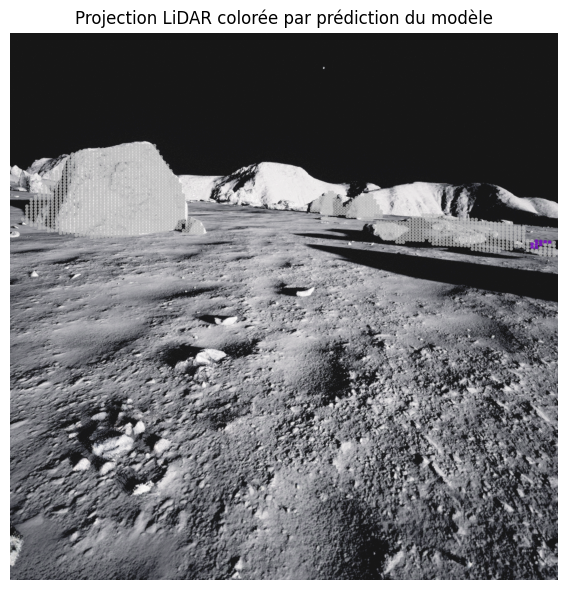

In [134]:
# Exemple
visualize_prediction_on_image(250)